In [1]:
import sys

MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scripts.models.conv2dlstm_oneshot_multistep as conv2dlstm
from utils.data_preprocessing import (
    compare_feature_statistics,
    create_dataset,
    moving_average_causal_filter,
    normalise_dataset,
    split_train_test_forecast_windows,
)
from utils.dataset import SlowEarthquakeDataset
from utils.general_functions import set_seed, set_torch_device
from utils.nn_train import eval_model_on_test_set, train_model
from utils.plotting import (
    plot_all_data_results,
    plot_metric_results,
    plot_original_vs_processed_data,
)

In [3]:
import torch
import torch.nn as nn
import torch.utils.data as data
import tqdm
from sklearn.preprocessing import MinMaxScaler

In [4]:
import json

with open("../conf.json", "r") as f:
    config = json.load(f)

In [5]:
SEED = 42
set_seed(SEED)

device = set_torch_device()

GPU name: NVIDIA A100-SXM4-40GB
Max GPU memory: 42.297786368 GiB


In [6]:
columns = {}
dataset = SlowEarthquakeDataset([f"cascadia_{i}_seg" for i in range(1, 6 + 1)])
dataset.load()

for i in range(1, 6 + 1):
    ds_exp = dataset[f"cascadia_{i}_seg"]
    X, Y, t = ds_exp["X"], ds_exp["Y"], ds_exp["t"]
    columns[f"seg_{i}_avg"] = X.reshape(-1)

ts_data = pd.DataFrame(columns) / 1e8
ts_data.head()

,seg_1_avg,seg_2_avg,seg_3_avg,seg_4_avg,seg_5_avg,seg_6_avg
0,1.510314,0.780134,0.064875,0.114083,-0.051013,0.016110
1,1.256806,0.970059,0.080977,0.070528,-0.012019,0.016997
2,1.074901,0.710642,0.145387,0.138937,0.118613,0.097997
3,1.447256,0.836337,0.173580,0.191626,0.116387,0.104032
4,1.787377,0.846635,0.164064,0.245032,0.144225,0.092539


In [7]:
SMOOTHING_WINDOW = config["cascadia"]["smoothing_window"]
DOWNSAMPLING_FACTOR = config["cascadia"]["downsampling_factor"]
df_smoothed = moving_average_causal_filter(
    ts_data, SMOOTHING_WINDOW, DOWNSAMPLING_FACTOR
)
df_smoothed.shape

(3874, 6)

In [8]:
results = compare_feature_statistics(ts_data, df_smoothed)
results

{'mean_comparison': {'t_statistic': array([0.04853684, 0.15708267, 0.14681992, 0.12610207, 0.03033323,
         0.08389474]),
  'p_value': array([0.96128966, 0.87518379, 0.88327798, 0.8996544 , 0.97580207,
         0.93314229]),
  'significant': array([False, False, False, False, False, False])},
 'variance_comparison': {'f_statistic': array([0.00235582, 0.02467496, 0.02155609, 0.01590173, 0.00092011,
         0.00703833]),
  'p_value': array([0.96128966, 0.87518379, 0.88327798, 0.8996544 , 0.97580207,
         0.93314229]),
  'significant': array([False, False, False, False, False, False])}}

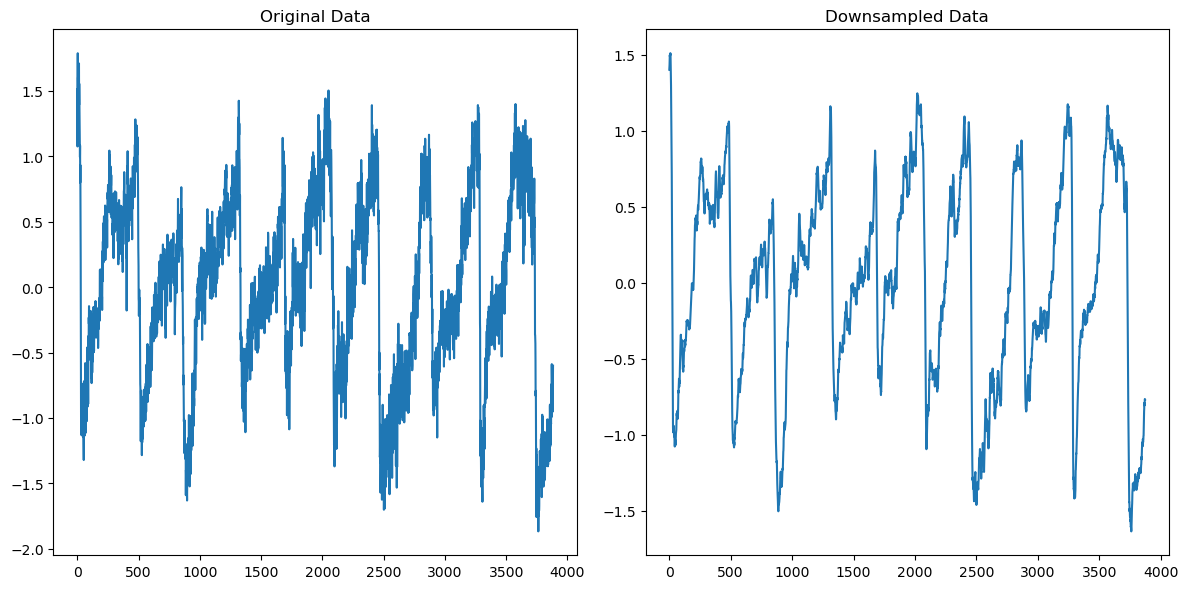

In [9]:
plot_original_vs_processed_data(
    ts_data.iloc[:, 0], df_smoothed.iloc[:, 0], "line", "Downsampled"
)

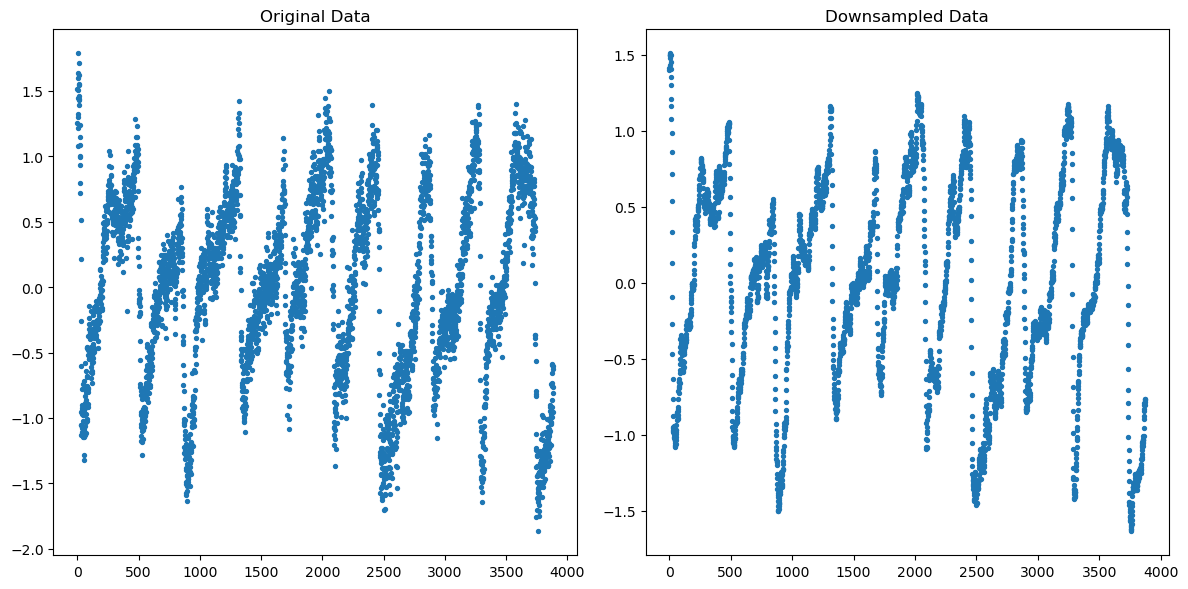

In [10]:
plot_original_vs_processed_data(
    ts_data.iloc[:, 0], df_smoothed.iloc[:, 0], "scatter", "Downsampled"
)

In [11]:
OPTUNA_PARAMS_PATH = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/scripts/optuna_results/p341cam_best_Conv2DLSTM_cascadia_1to6_2024-03-05T23:14:46.csv"

import csv

reader = csv.reader(open(OPTUNA_PARAMS_PATH, "r"))
optuna_params = {}
for row in reader:
    k, v = row
    optuna_params[k] = v

optuna_params

{'lookback': '260',
 'hidden_size': '32',
 'kernel_size': '3',
 'dropout': '0.010653752151705442'}

In [12]:
LOOKBACK, FORECAST = int(optuna_params["lookback"]), 30
N_FORECAST_WINDOWS = 15
N_VALIDATION_WINDOWS = 15

X, y = create_dataset(df_smoothed, LOOKBACK, FORECAST)
print(f"X and y shapes: {X.shape}, {y.shape}")

X and y shapes: torch.Size([3585, 260, 6]), torch.Size([3585, 30, 6])


In [13]:
(
    X_train,
    y_train,
    X_test,
    y_test,
    X_val,
    y_val,
) = split_train_test_forecast_windows(
    X, y, FORECAST, N_FORECAST_WINDOWS, N_VALIDATION_WINDOWS
)

print(f"Training data shapes: {X_train.shape}, {y_train.shape}")
print(f"Validation data shapes: {X_val.shape}, {y_val.shape}")
print(f"Testing data shapes: {X_test.shape}, {y_test.shape}")

Training data shapes: torch.Size([2670, 260, 6]), torch.Size([2670, 30, 6])
Validation data shapes: torch.Size([450, 260, 6]), torch.Size([450, 30, 6])
Testing data shapes: torch.Size([450, 260, 6]), torch.Size([450, 30, 6])


In [14]:
data_dict, scaler_X, scaler_y = normalise_dataset(
    X_train, y_train, X_test, y_test, X_val, y_val
)
data_dict.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc', 'X_val', 'y_val', 'X_val_sc', 'y_val_sc'])

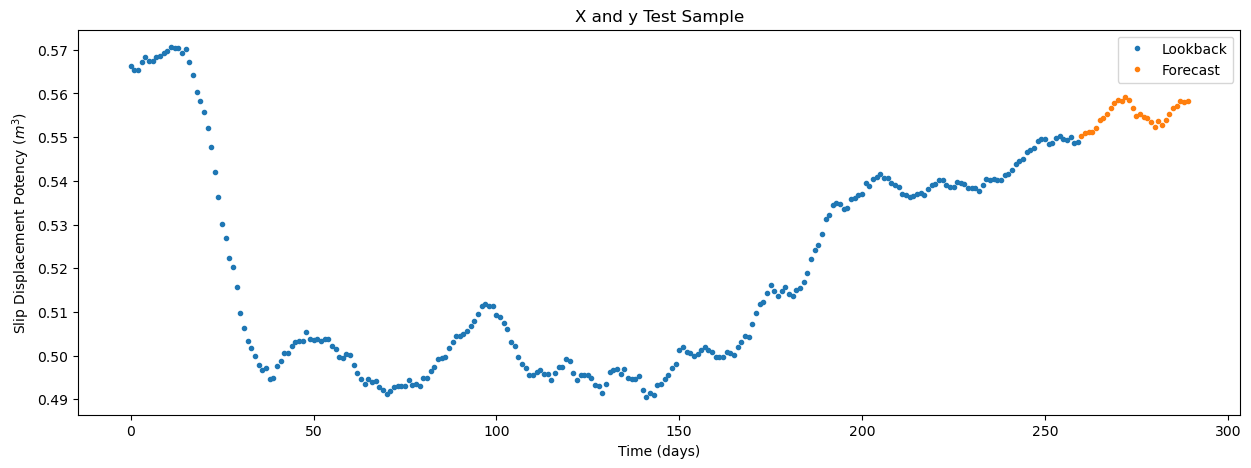

In [15]:
plt.figure(figsize=(15, 5))
plt.plot(data_dict["X_test_sc"][10, :, 2], ".", label="Lookback")
plt.plot(
    np.arange(LOOKBACK, LOOKBACK + FORECAST),
    data_dict["y_test_sc"][10, :, 2],
    ".",
    label="Forecast",
)

plt.title("X and y Test Sample")
plt.xlabel("Time (days)")
plt.ylabel("Slip Displacement Potency ($m^3$)")
plt.legend()
plt.show()

In [16]:
hidden_size = int(optuna_params["hidden_size"])
n_variates = len(df_smoothed.columns)
input_steps = LOOKBACK
output_steps = FORECAST
kernel_size = int(optuna_params["kernel_size"])

model = conv2dlstm.Conv2DLSTMModel(
    n_variates=n_variates,
    input_steps=input_steps,
    output_steps=output_steps,
    hidden_size=hidden_size,
    kernel_size=kernel_size,
)
model = model.to(device)

In [17]:
N_EPOCHS = 10
results_dict = train_model(model, N_EPOCHS, data_dict, scaler_y, device)

Training model on cuda


Epoch [10/10], Train RMSE: 0.1802, Val RMSE: 0.1793: 100%|████████████████████████████| 10/10 [00:09<00:00,  1.09it/s]


In [18]:
results_dict = eval_model_on_test_set(
    model, results_dict, data_dict, scaler_y, device
)

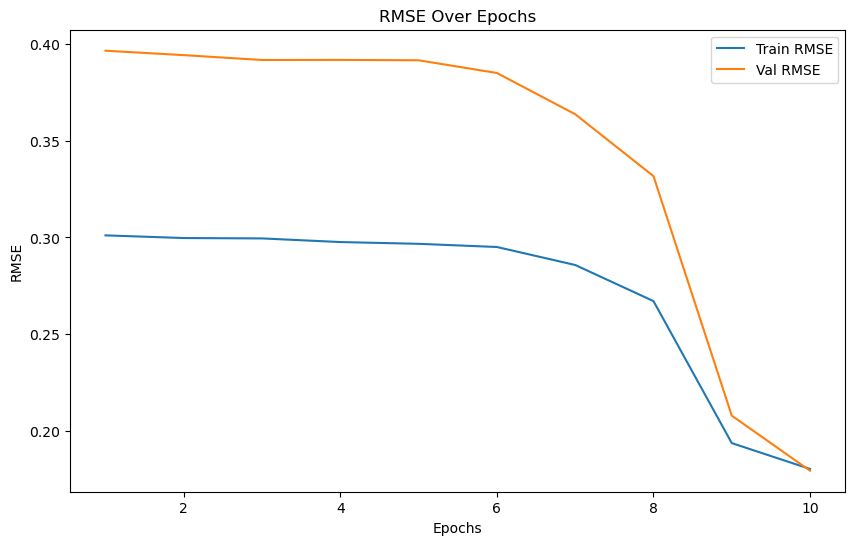

In [19]:
plot_metric_results(
    N_EPOCHS,
    results_dict["train_rmse_list"],
    results_dict["val_rmse_list"],
    "RMSE",
    val_or_test="Val",
)

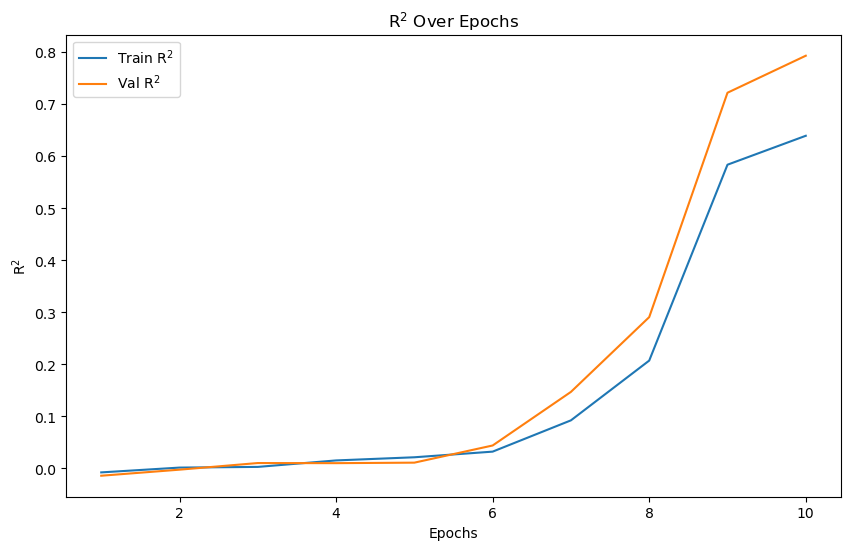

In [20]:
plot_metric_results(
    N_EPOCHS,
    results_dict["train_r2_list"],
    results_dict["val_r2_list"],
    "R$^2$",
    val_or_test="Val",
)

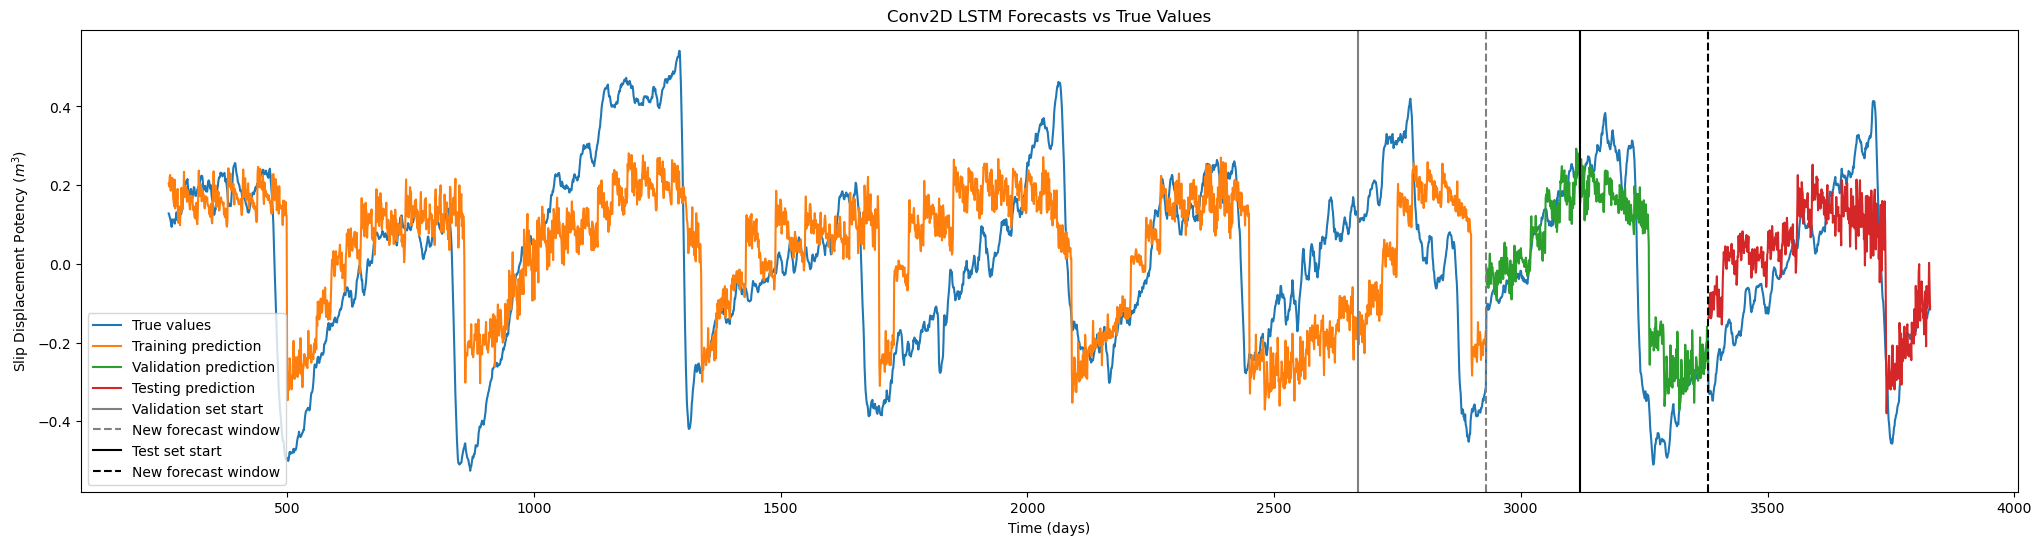

In [21]:
TITLE = "Conv2D LSTM Forecasts vs True Values"
X_LABEL = "Time (days)"
Y_LABEL = "Slip Displacement Potency ($m^3$)"
ith_segment = 1

plot_all_data_results(
    data_dict,
    results_dict,
    LOOKBACK,
    FORECAST,
    TITLE,
    X_LABEL,
    Y_LABEL,
    [],
    ith_segment,
)

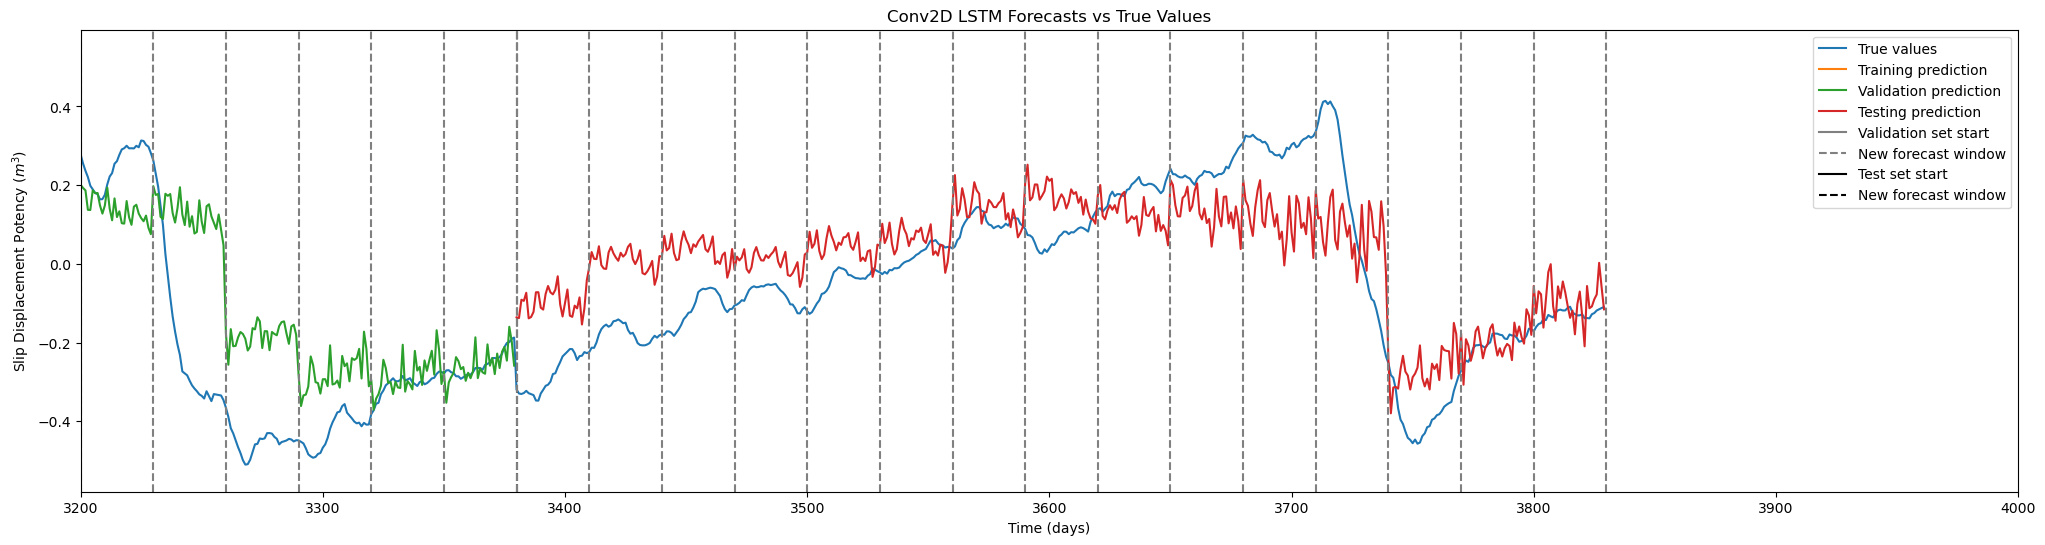

In [22]:
ZOOM_MIN = 3200
ZOOM_MAX = 4000
ZOOM_WINDOW = [ZOOM_MIN, ZOOM_MAX]

plot_all_data_results(
    data_dict,
    results_dict,
    LOOKBACK,
    FORECAST,
    TITLE,
    X_LABEL,
    Y_LABEL,
    ZOOM_WINDOW,
    ith_segment,
)